# Example Notebook For Associating Experimental Signals With The Carbon Network
Prior to running this notebook, the CarbonNetwork graphml file must be present in the build folder

In [1]:
import pandas as pd
import numpy as np
import glob as glob
import matplotlib.pyplot as plt
import networkx as nx
import os
import glob

from typing import List, Tuple

from tqdm.notebook import tqdm

# replace with submodules
# import sys
# sys.path.insert(0,'/global/homes/b/bpb/repos/metatlas')
# from metatlas.io import feature_tools as ft
# sys.path.insert(0,'/global/homes/b/bpb/repos/blink')
# import blink
sys.path.insert(0,'/global/homes/b/bpb/repos/envnet/envnet/use')
import analysis_tools as at

INFO:rdkit:Enabling RDKit 2023.09.1 jupyter extensions


In [2]:

# tolerance in ppm between experimental signal and node mz
mz_ppm_tolerance = 5
peak_height_min = 1e4
num_datapoints_min = 10
# minimum MSMS score 
msms_score_min = 0.5

# minimum MSMS matching ion count
msms_matches_min = 3

# retention time range in minutes for feature finding
rt_range = [1, 700]

# tolerance in daltons used for calculating MS/MS similarity scores
frag_mz_tolerance = 0.05

In [3]:
from importlib import reload
at = reload(at)

In [4]:
from metatlas.untargeted.tools import get_google_sheet
file_df = get_google_sheet(notebook_name='Supplementary Tables',sheet_name='Table 1a')
if not 'h5' in file_df.columns:
    file_df['h5'] = file_df['parquet'].str.replace('.parquet','.h5')
cols = ['parquet','h5','environmental_subclass']
file_df = file_df[cols]
envo_name = get_google_sheet(notebook_name='Supplementary Tables',sheet_name='Table 1b')
# file_df = pd.merge(file_df,envo_name[['name','id']],left_on='environmental_subclass',right_on='id',how='inner')
file_df = pd.merge(file_df,envo_name[['name','id','common parent name']],left_on='environmental_subclass',right_on='id',how='inner')

file_df = file_df[~file_df['h5'].str.contains('Frtlzr')]
file_df['basename'] = file_df['h5'].apply(os.path.basename)
file_df

,parquet,h5,environmental_subclass,name,id,common parent name,basename
0,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,ENVO:00002150,coastal sea water,ENVO:00002150,sea water,Copepodamide_28mM.h5
1,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,ENVO:00002150,coastal sea water,ENVO:00002150,sea water,PPLA_9.h5
2,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,ENVO:00002150,coastal sea water,ENVO:00002150,sea water,PPLA_11.h5
3,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,ENVO:00002150,coastal sea water,ENVO:00002150,sea water,NB_1.h5
4,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,ENVO:00002150,coastal sea water,ENVO:00002150,sea water,Copepodamide_288uM.h5
...,...,...,...,...,...,...,...
1447,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,ENVO:00005778,tropical soil,ENVO:00005778,soil,20210920_JGI-AK-TH_NB_504882_SoilWetDry_final_...
1448,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,ENVO:00005778,tropical soil,ENVO:00005778,soil,20210920_JGI-AK-TH_NB_504882_SoilWetDry_final_...
1449,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,ENVO:00005778,tropical soil,ENVO:00005778,soil,20210920_JGI-AK-TH_NB_504882_SoilWetDry_final_...
1450,/global/cfs/cdirs/metatlas/projects/carbon_net...,/global/cfs/cdirs/metatlas/projects/carbon_net...,ENVO:00005778,tropical soil,ENVO:00005778,soil,20210920_JGI-AK-TH_NB_504882_SoilWetDry_final_...


In [6]:
# df = pd.read_csv('/global/cfs/cdirs/metatlas/projects/carbon_network/public_and_internal_files_with_massive_and_redu.tsv', sep='\t')
# df = df[df['SampleType']=='plant']
# df = df[~df['buddy'].str.contains('qc',case=False)]
# df = df[~df['buddy'].str.contains('blank',case=False)]
# out_dir = '/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data'
# temp_files = df['h5'].tolist()
# files = []
# for f in temp_files:
#     base_dir = os.path.dirname(f)
#     base_name = os.path.basename(f)
#     new_dir = os.path.join(out_dir,base_dir)
#     new_name = os.path.join(new_dir,base_name)
#     files.append(new_name)
#     if not os.path.isfile(new_name):
#         print('File Not Found!')
#         print(new_name)
#         print(f)
# files_data = pd.DataFrame(files,columns=['filename'])
# files = files_data['filename'].tolist()


In [5]:
# collect and merge required data and metadata
node_data = at.graph_to_df()
node_atlas = at.make_node_atlas(node_data, rt_range)
merged_node_data = at.merge_spectral_data(node_data)
# files_data = at.get_files_df(exp_dir)
# files = files_data['filename'].tolist()

INFO:root:Processing envnet_original_spectra.mgf
INFO:root:Processing envnet_mdm_spectra.mgf


In [6]:
file_df.groupby('common parent name')['h5'].count()

common parent name
IHSS Reference Standards     27
fresh water                 236
sea water                   746
soil                        443
Name: h5, dtype: int64

In [7]:
node_data.shape

(12331, 80)

In [8]:
# get ms1 and ms2 data
files = file_df['h5'].tolist()
ms1_data = at.get_sample_ms1_data(node_atlas, files, mz_ppm_tolerance,peak_height_min,num_datapoints_min)
max_ms1_data = at.get_best_ms1_rawdata(ms1_data,node_data)
ms1_data.to_csv('../../data/Environments_ms1_data_0p1.csv')



files = file_df['parquet'].tolist()
ms2_data = at.get_sample_ms2_data(files,merged_node_data,msms_score_min,msms_matches_min,mz_ppm_tolerance,frag_mz_tolerance)
ms2_data = pd.concat([d for d in ms2_data if d is not None])
ms2_data.to_csv('../../data/Environments_ms2_data_0p1.csv')



  0%|          | 0/1452 [00:00<?, ?file/s]

In [ ]:
all_files = !find /global/cfs/cdirs/metatlas/raw_data/ -name "*.h5"
all_files = pd.DataFrame(all_files, columns=['full_filename'])
all_files['basename'] = all_files['full_filename'].apply(os.path.basename)
all_files['experiment'] = all_files['full_filename'].apply(lambda x: x.split('/')[-2])



unique_experiments = all_files[all_files['basename'].isin(file_df['basename'].unique())]['experiment'].unique()
all_files = all_files[all_files.experiment.isin(unique_experiments)]
all_files = all_files[all_files['basename'].str.contains('exctrl',case=False)]
all_files = all_files[all_files['basename'].str.contains('_NEG_',case=True)]

all_files.reset_index(drop=True,inplace=True)
all_files.to_csv('../../data/ExtractionControlFiles_ForMetatlasEnvironments.csv')

In [ ]:
all_files.shape

(48, 3)

In [ ]:
# get ms1 and ms2 data
files = all_files['full_filename'].tolist()
files = [f.replace('.h5','.mzML') for f in files]
ms1_data = at.get_sample_ms1_data(node_atlas, files, mz_ppm_tolerance,peak_height_min,num_datapoints_min)
max_ms1_data = at.get_best_ms1_rawdata(ms1_data,node_data)
ms1_data.to_csv('../../data/EnvironmentBackground_ms1_data_0p1.csv')



ms2_data = at.get_sample_ms2_data(files,merged_node_data,msms_score_min,msms_matches_min,mz_ppm_tolerance,frag_mz_tolerance)
ms2_data = pd.concat([d for d in ms2_data if d is not None])
ms2_data.to_csv('../../data/EnvironmentBackground_ms2_data_0p1.csv')



  0%|          | 0/48 [00:00<?, ?file/s]

[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_inde

  0%|          | 0/48 [00:00<?, ?file/s]

[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_inde

In [ ]:
files = !find /pscratch/sd/b/bpb/massive -name "*.mzML"
#exract from ms1_data['lcmsrun_observed'] the string that matches the pattern 'MSV\d+'
ms1_data = pd.read_csv('../../data/Environments_ms1_data_0p1.csv')

massive_ids = ms1_data.drop_duplicates('lcmsrun_observed')['lcmsrun_observed'].str.extract('MSV(\d+)').dropna().astype(int).drop_duplicates().values.flatten()


In [ ]:
files[0]

'/pscratch/sd/b/bpb/massive/v01/MSV000082048/peak/Plate_22/21_73.mzML'

In [ ]:

# pad the integer to look like this MSV000085555
# massive_ids = [str(i).zfill(10) for i in massive_ids]
# prepend 'MSV' to the ids
formatted_massive_ids = ['MSV%09d'%i for i in massive_ids]

filtered_files = [f for f in files if any(m in f for m in formatted_massive_ids)]
filtered_files = [f for f in filtered_files if 'blank' in f.lower()]
filtered_files = [f for f in filtered_files if 'neg' in f.lower()]
# filtered_files

# ms1_data[ms1_data['lcmsrun_observed'].str.contains('MSV')].iloc[0]['lcmsrun_observed']

In [ ]:
# for each file in filtered_files copy it to  /global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive_blanks
out_dir = '/global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive_blanks'
old_dir = '/pscratch/sd/b/bpb/massive'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
massive_blank_files = []
for f in filtered_files:
    new_name = f.replace(old_dir,out_dir)
    new_dir = os.path.dirname(new_name)
    massive_blank_files.append(new_name)
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)
    if not os.path.isfile(new_name):
        print(f'Copying {f} to {new_name}')
        !cp "$f" "$new_name"
with open('../../data/massive_blank_files.txt','w') as f:
    for item in massive_blank_files:
        f.write("%s\n" % item)

Copying /pscratch/sd/b/bpb/massive/v01/MSV000089361/updates/2022-05-03_FLEEgroup_7b306b7e/peak/mzml/NEG_MS2_mzml/DOM_Interlab_LC-MS_Lab32_neg_MS2_PPL_Blank.mzML to /global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive_blanks/v01/MSV000089361/updates/2022-05-03_FLEEgroup_7b306b7e/peak/mzml/NEG_MS2_mzml/DOM_Interlab_LC-MS_Lab32_neg_MS2_PPL_Blank.mzML
Copying /pscratch/sd/b/bpb/massive/v01/MSV000089361/updates/2022-05-03_FLEEgroup_7b306b7e/peak/mzml/NEG_MS2_mzml/DOM_Interlab_LC-MS_Lab32_neg_MS2_Blank_6.mzML to /global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive_blanks/v01/MSV000089361/updates/2022-05-03_FLEEgroup_7b306b7e/peak/mzml/NEG_MS2_mzml/DOM_Interlab_LC-MS_Lab32_neg_MS2_Blank_6.mzML
Copying /pscratch/sd/b/bpb/massive/v01/MSV000089361/updates/2022-05-03_FLEEgroup_7b306b7e/peak/mzml/NEG_MS2_mzml/DOM_Interlab_LC-MS_Lab32_neg_MS2_Blank_4.mzML to /global/cfs/cdirs/metatlas/projects/carbon_network/raw_data/massive_blanks/v01/MSV000089361/updates/2022-05-03_F

In [ ]:
len(filtered_files)

935

In [ ]:
# get ms1 and ms2 data

ms1_data = at.get_sample_ms1_data(node_atlas, filtered_files, mz_ppm_tolerance,peak_height_min,num_datapoints_min)
ms1_data.to_csv('../../data/EnvironmentBackground_MASSIVE_ms1_data_0p1.csv')

  0%|          | 0/935 [00:00<?, ?file/s]

[ Warning ] Found 3444 spectra and 0 chromatograms
[ Warning ] However Spectrum index list shows 4194 and Chromatogram index list shows 1 entries
[ Warning ] Updating offset dict with found offsets but some might be still missing
[ Warning ] This may happen because your is file truncated
Error in file: /pscratch/sd/b/bpb/massive/v01/MSV000087572/raw/mzML/NEG_MSMS_mzML/DOM_Interlab-LC-MS_Lab20_PPL-blank_Neg_MS2.mzML
no element found: line 198679, column 0
[ Warning ] Found 1379 spectra and 0 chromatograms
[ Warning ] However Spectrum index list shows 1419 and Chromatogram index list shows 0 entries
[ Warning ] Updating offset dict with found offsets but some might be still missing
[ Warning ] This may happen because your is file truncated
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False
[ Warning ] Found 1379 spectra and 0 chromatograms
[ Warning

In [ ]:
1+1

2

In [ ]:
ms1_data = pd.read_csv('../../data/Environments_ms1_data_0p1.csv')
ms1_exctrl = []
files = ['../../data/EnvironmentBackground_ms1_data_0p1.csv','../../data/EnvironmentBackground_MASSIVE_ms1_data_0p1.csv']
for f in files:
    ms1_exctrl.append(pd.read_csv(f))
ms1_exctrl = pd.concat(ms1_exctrl)
print(ms1_exctrl['lcmsrun_observed'].nunique())
# find duplicate control files
d_control = ms1_exctrl.pivot_table(columns='node_id',index=['lcmsrun_observed'],values='peak_area',aggfunc='mean',fill_value=0)
s = d_control.sum(axis=1)
s.sort_values(ascending=False,inplace=True)
good_files = s.drop_duplicates().index.to_list()
ms1_exctrl = ms1_exctrl[ms1_exctrl['lcmsrun_observed'].isin(good_files)]
print(ms1_exctrl['lcmsrun_observed'].nunique())

966
357


In [ ]:
# normalize the peak_area values by the max peak_area for each lcmsrun_observed
# normalize the data
d_sample = ms1_data.pivot_table(columns='node_id',index=['lcmsrun_observed'],values='peak_area',aggfunc='mean',fill_value=0)
# m = d_sample.min(axis=1)
# d_sample = d_sample.sub(m, axis=0)
# m = d_sample.max(axis=1)
# d_sample = d_sample.div(m, axis=0)
# d_sample.fillna(0,inplace=True)
d_control = ms1_exctrl.pivot_table(columns='node_id',index=['lcmsrun_observed'],values='peak_area',aggfunc='mean',fill_value=0)
# m = d_control.min(axis=1)
# d_control = d_control.sub(m, axis=0)
# m = d_control.max(axis=1)
# d_control = d_control.div(m, axis=0)
# d_control.fillna(0,inplace=True)
d = pd.concat([d_sample,d_control])
d.fillna(0,inplace=True)


In [ ]:
# for each column, get the top 10 lcmsrun_observed
top = 3
top_lcms = d.apply(lambda x: x.nlargest(top).index.isin(d_sample.index).all())
# top_lcms.reset_index(inplace=True)
# top_lcms = top_lcms.melt(id_vars='node_id',value_name='lcmsrun_observed')
top_lcms

node_id
8.0        True
9.0        True
10.0       True
11.0       True
13.0       True
           ... 
14947.0    True
14948.0    True
14949.0    True
14950.0    True
14951.0    True
Length: 11575, dtype: bool

In [ ]:
sum(top_lcms) / len(top_lcms)

0.9303671706263499

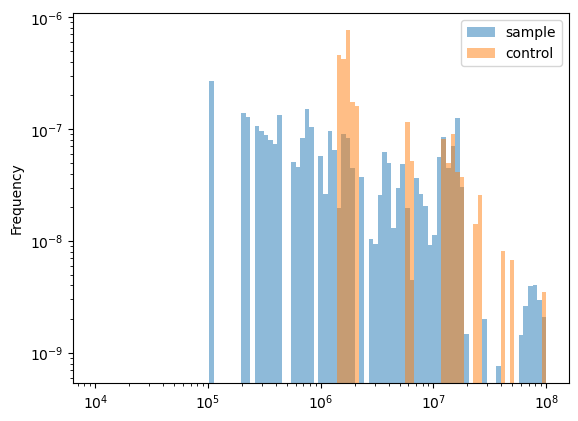

In [ ]:
fig,ax = plt.subplots()
n = 16
edges = np.logspace(4,8,100)
d_sample[n].plot(kind='hist',bins=edges,ax=ax,label='sample',alpha=0.5,density=True)
d_control[n].plot(kind='hist',bins=edges,ax=ax,label='control',alpha=0.5,density=True)
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()

In [ ]:
# # perform a non-parametric test to determine if the peak areas are significantly different between the two groups
# from scipy.stats import mannwhitneyu
# p_values = []
# cols = d_sample.columns
# for col in cols:
#     if col in d_control.columns:    
#         p = mannwhitneyu(d_control[col],d_sample[col]).pvalue
#         if p > 0.05:
#             p_values.append(col)
    

In [ ]:
import os
from IPython import get_ipython
from pathlib import Path

def get_notebook_dir():
    ipython = get_ipython()
    if ipython:
        notebook_dir = ipython.starting_dir
        return notebook_dir
    else:
        return os.getcwd()

module_path = os.path.join(Path(get_notebook_dir()).parents[1])


G = nx.read_graphml(os.path.join(module_path, 'data/envnet.graphml'))

# remove nodes where top_lcms is False
top_lcms_keep = top_lcms[top_lcms].index.astype(str).to_list()

nodes = [n for n in G.nodes() if n in top_lcms_keep]
G = G.subgraph(nodes).copy()

# remove nodes with no edges
nodes = [n for n in G.nodes() if G.degree(n) > 0]
G = G.subgraph(nodes).copy()

# remove nodes in subgraphs with less than 100 nodes
subgraphs = list(nx.connected_components(G))
subgraphs = [G.subgraph(s) for s in subgraphs]
subgraphs = [s for s in subgraphs if len(s) > 100]
G = nx.compose_all(subgraphs)
# write G to graphml
nx.write_graphml(G,os.path.join(module_path, 'data/envnet.graphml'))




In [ ]:

# get the edge data from T and store it as a data from with "source" and "target" and "weight" attributes
edge_data = nx.to_pandas_edgelist(G)
edge_data['source'] = edge_data['source'].astype(float).astype(int)
edge_data['target'] = edge_data['target'].astype(float).astype(int)
edge_data = edge_data[['source','target']]
edge_data.to_csv('../../data/edge_data.csv',index=None)

# get the node data from T and store it as a data from with "node" and "data" attributes
node_data = G.nodes(data=True)
node_data = pd.DataFrame(node_data)
node_data.columns = ['node','data']
node_data['data'] = node_data['data'].apply(lambda x: dict(x))
node_data = pd.concat([node_data.drop(['data'], axis=1), node_data['data'].apply(pd.Series)], axis=1)
node_data.to_csv('../../data/node_data.csv',index=None)

In [ ]:
node_data['inchi_key_identity'].nunique()


553